# Running a classifier on the Titanic Dataset

<img src="./images/titanic.jpg" style="width:820px; height:420px"/>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import to_categorical
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
# Load the data and randomize them.
df = pd.read_csv("./data/titanic.csv")
# Let's reformat the data making them easier to work with.
ticket_class = {1: "First", 2: "Second", 3: "Third"}
df["Ticket"] = df.apply(lambda row: ticket_class[row["Pclass"]], axis=1)
df=df.drop(columns=['Pclass', 'PassengerId'])
display(df)

,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,"Braund, Mr. Owen Harris",male,22.0,1,0,Third,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,First,71.2833,C85,C
2,1,"Heikkinen, Miss. Laina",female,26.0,0,0,Third,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,First,53.1000,C123,S
4,0,"Allen, Mr. William Henry",male,35.0,0,0,Third,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
886,0,"Montvila, Rev. Juozas",male,27.0,0,0,Second,13.0000,NaN,S
887,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,First,30.0000,B42,S
888,0,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,Third,23.4500,NaN,S
889,1,"Behr, Mr. Karl Howell",male,26.0,0,0,First,30.0000,C148,C


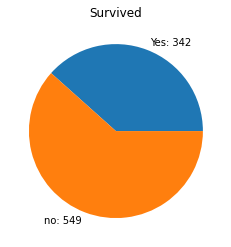

In [3]:
yes = df[df.Survived >=1].shape[0]
no = df[df.Survived == 0].shape[0]
counters = [yes, no]
_ = plt.pie(counters, labels=[f"Yes: {yes}", f"no: {no}"])
_ = plt.title("Survived")

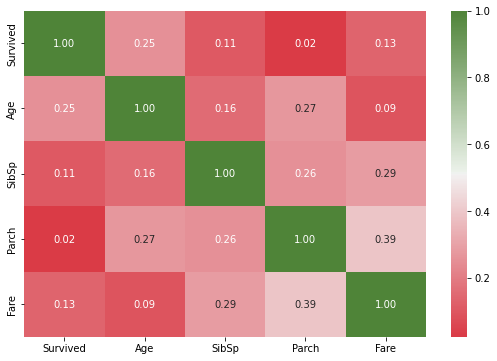

In [4]:
def show_correlation_graph(data, title=None, cmap=None, linewidths=0, figsize=(9, 6), annot=True):
    """Utility to plot the correlation graph for the passed in data."""
    if cmap is None:
        cmap = sns.diverging_palette(10, 120, as_cmap=True)
    data = data.dropna()    
    corr = data.corr()
    for column_name in corr.columns:
        corr[column_name] = corr[column_name].abs()
    _, ax = plt.subplots(figsize=figsize)
    if title:
        ax.set_title(title)

    sns.heatmap(corr, annot=annot, fmt="2.2f", linewidths=linewidths, ax=ax, cmap=cmap)    
    
show_correlation_graph(df)


In [5]:
def plot_survival_rate(df, column_name):
    counters = [len(df[df[column_name] == p_class]) for p_class in df[column_name].unique()]
    labels = []
    for label, count in zip(df[column_name].unique(), counters):
        labels.append(f"{label} - Count {count}")
    plt.pie(counters, labels=labels)
    plt.title(f"Break Down by {column_name}")
    p_classes = sorted(list(df[column_name].unique()))
    plt.show()
    data = []
    for c in p_classes:
        c1 = df[df[column_name] == c]
        survived = c1[c1.Survived==1].shape[0]
        not_survived = c1[c1.Survived==0].shape[0]  
        survival_rate = int((survived / (not_survived + survived)) * 100)/100
        data.append([ f"{c}", survived, not_survived, survival_rate]  )
    f1 = pd.DataFrame(data, columns=[ column_name, 'S', 'N', 'Rate'])
    display(f1)
    sns.barplot(x =column_name,y ='Rate',  data = f1).set(title=f'Survival Rate by {column_name}')
    plt.show()


# Ticket

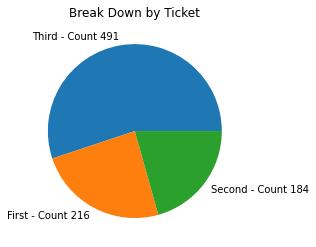

,Ticket,S,N,Rate
0,First,136,80,0.62
1,Second,87,97,0.47
2,Third,119,372,0.24


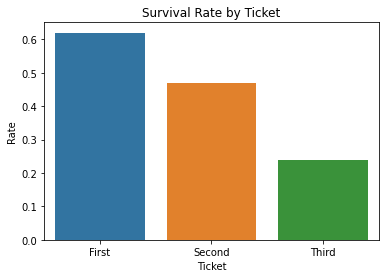

In [6]:
plot_survival_rate(df, "Ticket")

# Sex

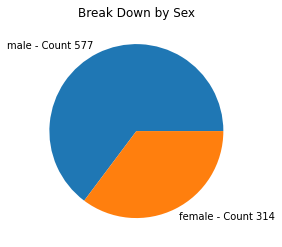

,Sex,S,N,Rate
0,female,233,81,0.74
1,male,109,468,0.18


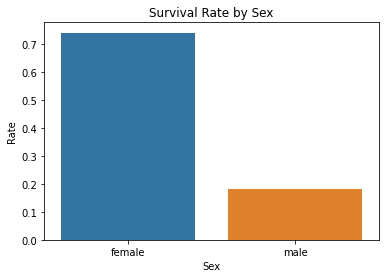

In [7]:
plot_survival_rate(df, "Sex")

# Age

In [8]:
print(f"Rows with a Null age: {df['Age'].isnull().sum()}")

Rows with a Null age: 177


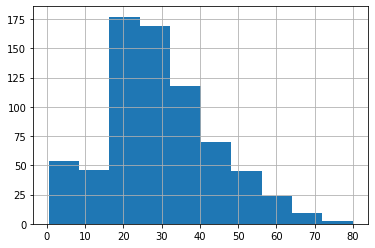

In [9]:
_ = df.Age.hist()

In [10]:
mean_ages = {}
prefixes = ('Mr.', 'Mrs.', 'Miss.', 'Master.', 'Dr.', 'Ms.')
for prefix in prefixes:
    mean_ages[prefix] = df[df["Name"].str.contains(prefix, na=False)]['Age'].mean().round()
mean_ages    

{'Mr.': 33.0,
 'Mrs.': 36.0,
 'Miss.': 22.0,
 'Master.': 5.0,
 'Dr.': 39.0,
 'Ms.': 28.0}

In [11]:
def get_age(row):
    if pd.isnull(row["Age"]):
        for prefix in prefixes:
            if prefix in row["Name"]:
                return mean_ages[prefix]
        assert "Could not assign age to nan field."
    else:
        return row["Age"]

df["Age"] = df.apply(get_age, axis=1)

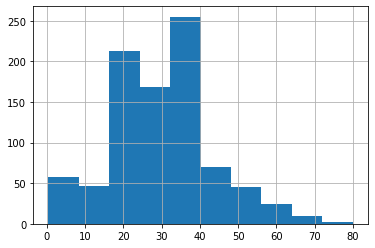

In [12]:
_ = df.Age.hist()

In [13]:
assert 0 == df['Age'].isnull().sum()

# Embarked

In [14]:
df["Embarked"].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [15]:
df["Embarked"].fillna('n/a', inplace=True)

In [16]:
df["Embarked"].unique()

array(['S', 'C', 'Q', 'n/a'], dtype=object)

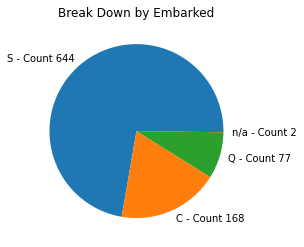

,Embarked,S,N,Rate
0,C,93,75,0.55
1,Q,30,47,0.38
2,S,217,427,0.33
3,n/a,2,0,1.00


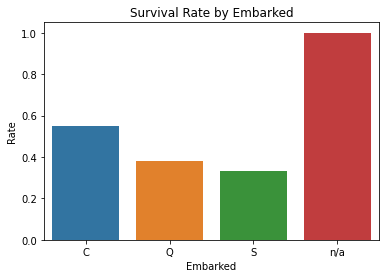

In [17]:
plot_survival_rate(df, "Embarked")

In [18]:
df.drop(df[df['Embarked'] =="n/a"].index, inplace = True)
df["Embarked"].unique()

array(['S', 'C', 'Q'], dtype=object)

In [19]:
df

,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,"Braund, Mr. Owen Harris",male,22.0,1,0,Third,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,First,71.2833,C85,C
2,1,"Heikkinen, Miss. Laina",female,26.0,0,0,Third,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,First,53.1000,C123,S
4,0,"Allen, Mr. William Henry",male,35.0,0,0,Third,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
886,0,"Montvila, Rev. Juozas",male,27.0,0,0,Second,13.0000,NaN,S
887,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,First,30.0000,B42,S
888,0,"Johnston, Miss. Catherine Helen ""Carrie""",female,22.0,1,2,Third,23.4500,NaN,S
889,1,"Behr, Mr. Karl Howell",male,26.0,0,0,First,30.0000,C148,C


# Cabin

In [20]:
def get_cabin_type(row):
    cabin = row["Cabin"]
    return 'X' if cabin is np.nan else cabin[0]


df["CabinType"] = df.apply(lambda row: get_cabin_type(row), axis=1)
df.drop(columns=['Cabin'], inplace = True)
df

,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,CabinType
0,0,"Braund, Mr. Owen Harris",male,22.0,1,0,Third,7.2500,S,X
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,First,71.2833,C,C
2,1,"Heikkinen, Miss. Laina",female,26.0,0,0,Third,7.9250,S,X
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,First,53.1000,S,C
4,0,"Allen, Mr. William Henry",male,35.0,0,0,Third,8.0500,S,X
...,...,...,...,...,...,...,...,...,...,...
886,0,"Montvila, Rev. Juozas",male,27.0,0,0,Second,13.0000,S,X
887,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,First,30.0000,S,B
888,0,"Johnston, Miss. Catherine Helen ""Carrie""",female,22.0,1,2,Third,23.4500,S,X
889,1,"Behr, Mr. Karl Howell",male,26.0,0,0,First,30.0000,C,C


# Has relatives on board

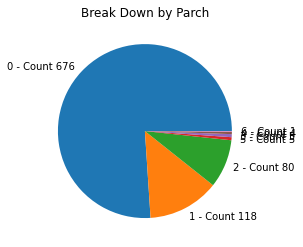

,Parch,S,N,Rate
0,0,231,445,0.34
1,1,65,53,0.55
2,2,40,40,0.50
3,3,3,2,0.60
4,4,0,4,0.00
5,5,1,4,0.20
6,6,0,1,0.00


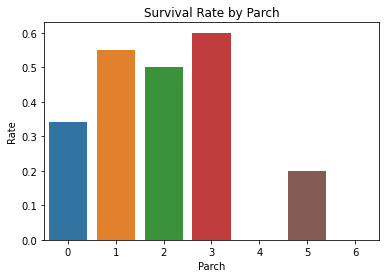

In [21]:
plot_survival_rate(df, "Parch")

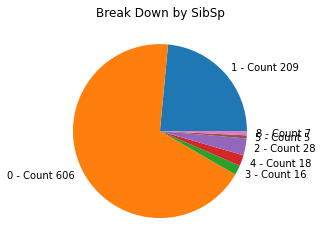

,SibSp,S,N,Rate
0,0,208,398,0.34
1,1,112,97,0.53
2,2,13,15,0.46
3,3,4,12,0.25
4,4,3,15,0.16
5,5,0,5,0.00
6,8,0,7,0.00


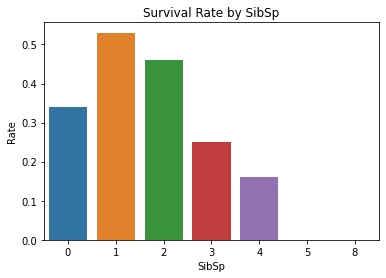

In [22]:
plot_survival_rate(df, "SibSp")

In [23]:
def has_siblings_on_board(row):
    counter = row["SibSp"] + row["Parch"]
    return row["SibSp"] > 0

def has_parents_on_board(row):
    return row["Parch"] > 0


df["Siblings"] = df.apply(lambda row: has_siblings_on_board(row), axis=1)
df["Parents"] = df.apply(lambda row: has_parents_on_board(row), axis=1)

df.drop(columns=["SibSp", "Parch"], inplace = True)
df

,Survived,Name,Sex,Age,Ticket,Fare,Embarked,CabinType,Siblings,Parents
0,0,"Braund, Mr. Owen Harris",male,22.0,Third,7.2500,S,X,True,False
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,First,71.2833,C,C,True,False
2,1,"Heikkinen, Miss. Laina",female,26.0,Third,7.9250,S,X,False,False
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,First,53.1000,S,C,True,False
4,0,"Allen, Mr. William Henry",male,35.0,Third,8.0500,S,X,False,False
...,...,...,...,...,...,...,...,...,...,...
886,0,"Montvila, Rev. Juozas",male,27.0,Second,13.0000,S,X,False,False
887,1,"Graham, Miss. Margaret Edith",female,19.0,First,30.0000,S,B,False,False
888,0,"Johnston, Miss. Catherine Helen ""Carrie""",female,22.0,Third,23.4500,S,X,True,True
889,1,"Behr, Mr. Karl Howell",male,26.0,First,30.0000,C,C,False,False


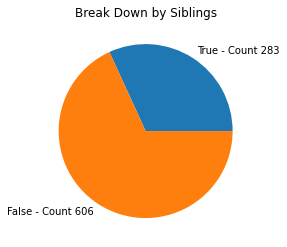

,Siblings,S,N,Rate
0,False,208,398,0.34
1,True,132,151,0.46


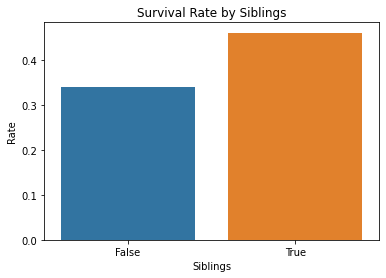

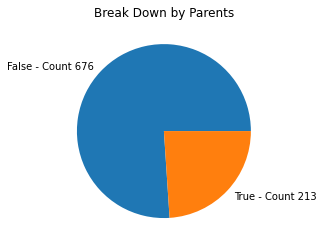

,Parents,S,N,Rate
0,False,231,445,0.34
1,True,109,104,0.51


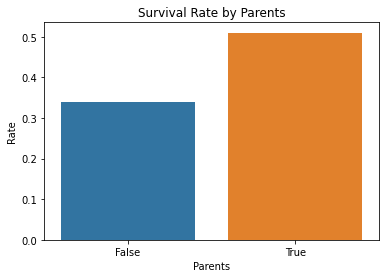

In [24]:
plot_survival_rate(df, "Siblings")
plot_survival_rate(df, "Parents")

# Prepare the data for training

In [25]:
def noninal_with_categories(df, column_name):
    temp = df.copy()
    dummies = pd.get_dummies(temp[column_name], prefix=column_name)
    new_frame = pd.concat( [temp, dummies], axis=1, join="inner")
    return new_frame.drop(columns=[column_name])
    

### Create a subset of the original dataset using the preprocessed data.

In [26]:
data = df[["Sex","Age","Ticket","Embarked","CabinType","Siblings", "Parents", "Survived", "Fare"]].copy()
#data = df[["Sex","Ticket","Embarked","CabinType","HasRelatives","Survived"]].copy()
display(data)

,Sex,Age,Ticket,Embarked,CabinType,Siblings,Parents,Survived,Fare
0,male,22.0,Third,S,X,True,False,0,7.2500
1,female,38.0,First,C,C,True,False,1,71.2833
2,female,26.0,Third,S,X,False,False,1,7.9250
3,female,35.0,First,S,C,True,False,1,53.1000
4,male,35.0,Third,S,X,False,False,0,8.0500
...,...,...,...,...,...,...,...,...,...
886,male,27.0,Second,S,X,False,False,0,13.0000
887,female,19.0,First,S,B,False,False,1,30.0000
888,female,22.0,Third,S,X,True,True,0,23.4500
889,male,26.0,First,C,C,False,False,1,30.0000


### Substitute the nominal columns with categorical data.

In [27]:
data = noninal_with_categories(data, "Sex")
data = noninal_with_categories(data, "Parents")
data = noninal_with_categories(data, "Siblings")
data = noninal_with_categories(data, "CabinType")
data = noninal_with_categories(data, "Embarked")
data = noninal_with_categories(data, "Ticket")
display(data)


,Age,Survived,Fare,Sex_female,Sex_male,Parents_False,Parents_True,Siblings_False,Siblings_True,CabinType_A,...,CabinType_F,CabinType_G,CabinType_T,CabinType_X,Embarked_C,Embarked_Q,Embarked_S,Ticket_First,Ticket_Second,Ticket_Third
0,22.0,0,7.2500,0,1,1,0,0,1,0,...,0,0,0,1,0,0,1,0,0,1
1,38.0,1,71.2833,1,0,1,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
2,26.0,1,7.9250,1,0,1,0,1,0,0,...,0,0,0,1,0,0,1,0,0,1
3,35.0,1,53.1000,1,0,1,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,35.0,0,8.0500,0,1,1,0,1,0,0,...,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,0,13.0000,0,1,1,0,1,0,0,...,0,0,0,1,0,0,1,0,1,0
887,19.0,1,30.0000,1,0,1,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
888,22.0,0,23.4500,1,0,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,1
889,26.0,1,30.0000,0,1,1,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0


In [28]:
X = data.copy()
Y = pd.DataFrame(X.pop("Survived"))
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print("Number of rows")
print("Train", X_train.shape[0])
print("Test", X_test.shape[0])


Number of rows
Train 711
Test 178


# Build a Random Forest Model

In [29]:
clf = RandomForestClassifier(n_estimators=100, max_features='sqrt')
clf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(max_features='sqrt')

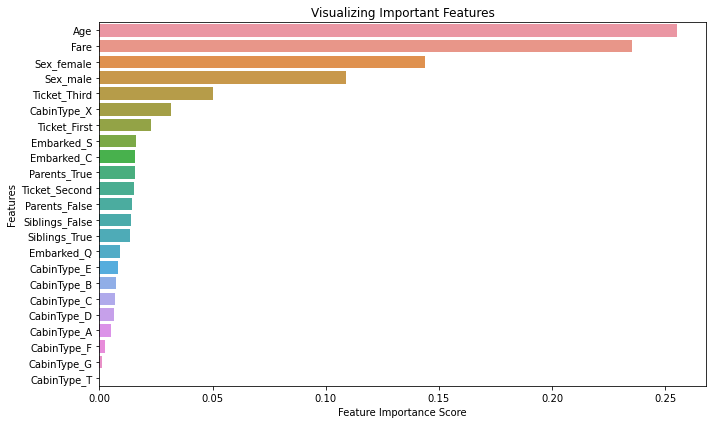

In [30]:

feature_imp = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.tight_layout()


In [31]:
y_pred = clf.predict(X_test)
accuracy_rf = clf.score(X_test, np.ravel(y_test))
print(f'accuracy: {accuracy_rf}')

accuracy: 0.848314606741573
